# Research sandbox

Optimal velocity function: 

$V:s \mapsto V(s),$ \
$V(s) = \max\{0, \ v_0 -v_0\exp(-\lambda v_0^{-1}(s -s_0)) \},$ \
$V'(s) = H(s -s_0)\lambda\exp(-\lambda v_0^{-1}(s -s_0)),$ \
$V^{-1}(v) = -\lambda^{-1}v_0 \log(1-v_0^{-1}v)+s_0,\ 0<v<v_0.$

Heterogeneous OV Model with Relaxed Noise: 

$\begin{equation}
  \begin{cases}
    \dot \varepsilon_n = -b^{-1}\varepsilon_n +a \xi_n,\\
    \dot v_n = \tau_n^{-1}[{w(V_n+\varepsilon_n)-v_n}],\\
    \dot x_n = v_n,
  \end{cases}
\end{equation}$

$
\begin{equation}
  \begin{cases}
  \varepsilon_n(t+\delta) = (1-\delta b^{-1})\varepsilon_n(t) + a\sqrt{\delta} \eta_n,\ \eta_n \sim \mathcal{N}(0,\,1),\\
    v_n(t+\delta) = v_n(t) + \delta \tau_n^{-1}[{w(V_n +\varepsilon_n(t+\delta))-v_n(t)}],\\
    x_n(t+\delta) = x_n(t) + \delta v_n(t+\delta).
  \end{cases}
\end{equation}$

Anticipatory Operational Navigation: 

$\begin{equation}
  f(\alpha)=\min\{d_{\max}, v_0 \Delta t(\alpha)\}
\end{equation}$
 $\begin{equation}
     \alpha_0=\begin{cases}
    0,&\max\{f(\alpha^-),f(\alpha^+)\}=d_{\max}\\
\mathrm{argmax} {f(\alpha)},&\max\{f(\alpha^-),f(\alpha^+)\}<d_{\max}\\
    \end{cases}
\end{equation}$
$\begin{equation}
  \dot \alpha = \tau^{-1}\left[\alpha_0-\alpha\right]
\end{equation}$

In [1]:
import json
import logging
import os
import warnings
import zipfile

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from tqdm.notebook import tqdm

In [3]:
from math import exp
from numpy import arange, array, degrees, diff, mean, sign, unique, where
from numpy.linalg import norm
from numpy.polynomial import Polynomial
from numpy.random import default_rng
from scipy.optimize import minimize, root_scalar
from scipy.stats import linregress
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
from pNeuma_simulator import params
from pNeuma_simulator.animations import ring
from pNeuma_simulator.gang import decay
from pNeuma_simulator.initialization import ov
from pNeuma_simulator.results import percolate

In [5]:
warnings.filterwarnings("ignore")
rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
        "mathtext.fontset": "stixsans",
        "mathtext.default": "regular",
        "font.size": 7,
        "axes.titlesize": 7,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.linewidth": 0.25,
        "xtick.major.width": 0.25,
        "ytick.major.width": 0.25,
        "xtick.minor.width": 0.25,
        "ytick.minor.width": 0.25,
        # "pdf.fonttype": 42,
    }
)
logging.getLogger("matplotlib.font_manager").disabled = True

In [6]:
# probe = False
# if probe:
#     permutation = (4, 6)
#     items = loader(permutation, path)
#     accidents = 0
#     locations = []
#     for item in items:
#         if isinstance(item[0], list):
#             pass
#         else:
#             locations.append(item)
#             accidents += 1
#     error = accidents / len(items)
#     print(error)

In [7]:
# non_empty = []
# empty = []
# items = None
# n_cars = 12
# n_moto = 8
# permutation = (n_cars, n_moto)
# n_cars, n_moto = permutation
# load = True
# if load:
#    items = loader(permutation, path="./output/")
# for item in items:
#    if isinstance(item[0], list):
#        non_empty.append(item)
#    else:
#        empty.append(item)
# len(non_empty)

In [8]:
path = "./output/"
os.makedirs(path, exist_ok=True)
n_cars = 12
n_moto = 6
permutation = (n_cars, n_moto)

In [9]:
# def loader(permutation, verbose=True):
verbose = True
items = []
with zipfile.ZipFile(f"{path}{permutation}_det.zip", "r") as ziph:
    # ziph is zipfile handle
    for filename in ziph.namelist():
        if filename.endswith(").jsonl"):
            # Opening JSONL file
            with ziph.open(filename, "r") as openfile:
                # Reading from JSONL file
                # https://stackoverflow.com/questions/2081836/
                for i, line in enumerate(tqdm(openfile)):
                    item = json.loads(line)
                    if isinstance(item[0], list):
                        items.append(item)
                if verbose:
                    print(openfile.name)
#   return items

0it [00:00, ?it/s]

(12, 6).jsonl


In [10]:
len(items)

64

In [44]:
# Pseudorandom number generator
seed = 1
rng = default_rng(seed)
T_max = round(exp(params.CM))
NU = 1.096854  # theoretical exponent for directed percolation in 1D

In [54]:
def loss(x, y, x_star):
    renorm = np.abs(x - x_star)
    slope, _, _, _, _ = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
    return abs(NU - slope)

In [55]:
def fit(x, y):
    # https://stackoverflow.com/questions/3843017/
    zero_crossings = where(diff(sign(y)))[0]
    x0 = x[zero_crossings[0]]
    # https://stackoverflow.com/questions/24767191/
    res = minimize(lambda x_star: loss(x, y, x_star), method="Nelder-Mead", x0=x0)
    popt = res.x[0]
    return popt

In [56]:
# n_veh = 2 * n_cars + n_moto
# lam = np.empty(shape=n_veh, dtype=float)
# v0 = np.empty(shape=n_veh, dtype=float)
# s0 = np.empty(shape=n_veh, dtype=float)
# for item in items:
#    if isinstance(item[0], list):
#        for t, frame in enumerate(item[0]):
#            if t == 0:
#                for j, _ in enumerate(frame):
#                    v0[j] = frame[j]["v0"]
#                    lam[j] = frame[j]["lam"]
#                    s0[j] = frame[j]["s0"]
# v_max = list(ov(params.d_max, lam, v0, s0))

In [15]:
percolation = percolate(items, n_cars, n_moto, rng, start=5)

In [60]:
permutation = (12, 6)
x, y, low, high = percolation
x, y, low, high = array(x), array(y), array(low), array(high)
T_c = fit(array(x), y)
renorm = abs(T_c - x)
slope, intercept, r_value, p_value, std_err = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
p_c = 1 - T_c / T_max
print(abs(NU - slope), T_c, r_value**2)

1.4838490145496763e-05 40.43959312438964 0.9943924065054723


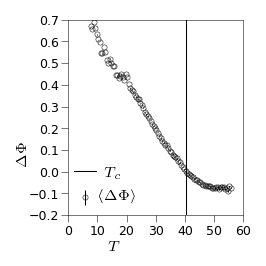

In [61]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
yerr = np.array(list(zip(y - low, high - y))).T
ax.errorbar(
    x,
    y,
    yerr=yerr,
    ms=5,
    fmt=".",
    mec="k",
    mfc="none",
    mew=0.25,
    ecolor="k",
    elinewidth=0.5,
    label="$\\langle \\Delta\\Phi \\rangle$",
)
ax.text(
    0.4,
    0.06,
    "$\\langle \\Delta\\Phi \\rangle$",
    ha="right",
    va="bottom",
    fontsize=7,
    transform=ax.transAxes,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
    usetex=True,
    zorder=10,
)
ax.text(
    0.3,
    0.18,
    "$T_c$",
    ha="right",
    va="bottom",
    fontsize=7,
    transform=ax.transAxes,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
    usetex=True,
    zorder=10,
)
ax.set_xlim(0, 60)
ax.set_ylim(-0.2, 0.6)
ax.set_xticks(arange(0, 70, 10))
ax.set_yticks(arange(-0.2, 0.8, 0.1))
ax.axvline(
    T_c,
    c="k",
    lw=0.5,
    ls="-",
    label="$T_c$",
)
ax.set_xlabel("Temperature $T$", usetex=True, labelpad=0)
ax.set_ylabel("Percolation $\\Delta\\Phi$", usetex=True, labelpad=0)
ax.legend(
    loc=[0, 0.015],
    frameon=False,
    handletextpad=0.5,
    handlelength=1.5,
    fontsize=7,
)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"percolation.pdf", format="pdf", transparent=True)

In [62]:
def draw_law(x, y, r_value, save=False):
    fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
    ax.set_aspect("equal")
    _ = plt.loglog(
        x[y > 0],
        y[y > 0],
        ".",
        mec="k",
        mfc="none",
        ms=5,
        mew=0.25,
    )
    p_fitted = Polynomial.fit(np.log(x[y > 0]), np.log(y[y > 0]), deg=1)
    plt.plot(
        np.exp(unique(np.log(x)[y > 0])),
        np.exp(p_fitted(unique(np.log(x)[y > 0]))),
        c="k",
        ls="-",
        lw=0.5,
    )
    ax.text(
        0.05,
        0.95,
        f"$R^2$= {r_value:.3f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.07,
        0.8,
        f"$\\nu$= {slope:.4f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.95,
        0.2,
        f"$T_c$= {T_c:.2f}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.95,
        0.05,
        f"permutation {permutation}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.set_ylabel("$\\langle \\Delta \\Phi \\rangle^+$", usetex=True, labelpad=0)
    ax.set_xlabel("$|T-T_c|$", usetex=True, labelpad=0)
    ax.tick_params(axis="x", pad=0)
    ax.tick_params(axis="y", pad=0)
    fig.tight_layout(pad=0)
    if save:
        plt.savefig(
            # f"./power-laws/power-law{permutation}.pdf", format="pdf", transparent=True
            f"./power-law{permutation}.pdf",
            format="pdf",
            transparent=True,
        )

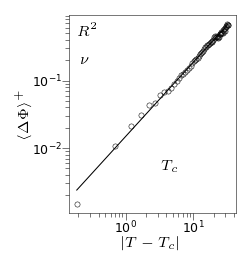

In [63]:
draw_law(renorm, y, r_value**2, save=False)

In [21]:
def inner_loop(frame, v_max):
    deg_range = []
    vel_car = []
    vel_x = []
    vel_y = []
    for j, _ in enumerate(frame):
        vel = frame[j]["vel"]
        if frame[j]["ID"] <= 2 * n_cars:
            vel_car.append(vel[0] / v_max[j])
        else:
            alphas = decay(array(vel), frame[j]["theta"])
            degs = degrees(alphas)
            deg_range.append(degs[0] - degs[-1])
            vel_x.append(vel[0] / v_max[j])
            vel_y.append(vel[1] / v_max[j])
        phi_cars = mean(vel_car)
        phi_moto = norm([sum(vel_x), sum(vel_y)]) / n_moto
    return deg_range, phi_cars, phi_moto

In [22]:
start = int(len(item[0]) * 2 / 3 - 1)

In [23]:
l_n = []
for n, item in enumerate(items):
    if isinstance(item[0], list):
        l_T = []
        l_DPhi = []
        frames = []
        n_veh = 2 * n_cars + n_moto
        lam = np.empty(shape=n_veh, dtype=float)
        v0 = np.empty(shape=n_veh, dtype=float)
        s0 = np.empty(shape=n_veh, dtype=float)
        for t, frame in enumerate(item[0]):
            if t == 0:
                for j, _ in enumerate(frame):
                    v0[j] = frame[j]["v0"]
                    lam[j] = frame[j]["lam"]
                    s0[j] = frame[j]["s0"]
            v_max = list(ov(params.d_max, lam, v0, s0))
            if t > start:
                deg_range, phi_cars, phi_moto = inner_loop(frame, v_max)
                if round(mean(deg_range)) == int(2 * T_c):
                    frames.append(t)
                    l_T.append(mean(deg_range))
                    l_DPhi.append(phi_moto - phi_cars)
        l_T = np.round(l_T) / 2
        if 0 < len(l_T) < 20:
            print(n)
            l_n.append(n)

21
29
38


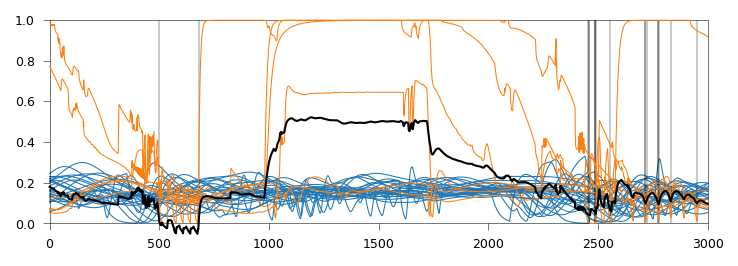

In [64]:
fig, ax = plt.subplots(figsize=(12 * params.cm, 4 * params.cm), dpi=150)
item = items[l_n[1]]
ar = array(item[0])
n_veh = 2 * n_cars + n_moto
lam = np.empty(shape=n_veh, dtype=float)
v0 = np.empty(shape=n_veh, dtype=float)
s0 = np.empty(shape=n_veh, dtype=float)
frame = item[0][0]
for j, _ in enumerate(frame):
    v0[j] = frame[j]["v0"]
    lam[j] = frame[j]["lam"]
    s0[j] = frame[j]["s0"]
v_max = list(ov(params.d_max, lam, v0, s0))
for i in range(ar.shape[1]):
    speeds = []
    for d in ar[start::1, -(i + 1)]:
        speed = d["vel"][0] / v_max[-(i + 1)]
        speeds.append(speed)
    if d["ID"] <= 2 * n_cars:
        zorder = 0
        c = "tab:blue"
    else:
        zorder = 10
        c = "tab:orange"
    plt.plot(speeds, c=c, lw=0.5, clip_on=False, zorder=zorder)
if n_moto > 0:
    l_DPhi = []
    for t, frame in enumerate(item[0]):
        if t > start:
            deg_range, phi_cars, phi_moto = inner_loop(frame, v_max)
            l_DPhi.append(phi_moto - phi_cars)
            if round(mean(deg_range)) == int(2 * T_c):
                plt.axvline(t - start, c="k", ls="-", lw=0.2)
    plt.plot(l_DPhi, c="k", lw=1, clip_on=False, zorder=100)
ax.set_xlim(0, ar.shape[0] - (start + 1))
ax.set_ylim(0, 1)
fig.tight_layout(pad=0)

In [65]:
frames = []
n_veh = 2 * n_cars + n_moto
lam = np.empty(shape=n_veh, dtype=float)
v0 = np.empty(shape=n_veh, dtype=float)
s0 = np.empty(shape=n_veh, dtype=float)
for t, frame in enumerate(item[0]):
    if t == 0:
        for j, _ in enumerate(frame):
            v0[j] = frame[j]["v0"]
            lam[j] = frame[j]["lam"]
            s0[j] = frame[j]["s0"]
    v_max = list(ov(params.d_max, lam, v0, s0))
    if t > start:
        for j, _ in enumerate(frame):
            deg_range, phi_cars, phi_moto = inner_loop(frame, v_max)
        if np.round(mean(deg_range)) == int(2 * T_c):
            frames.append(t)

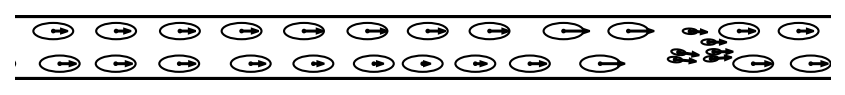

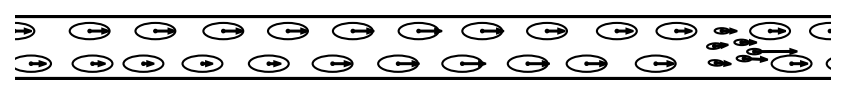

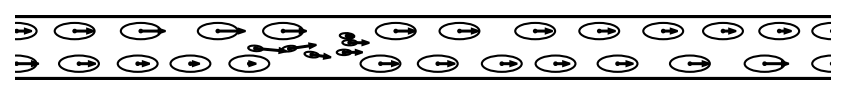

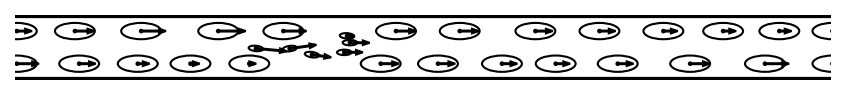

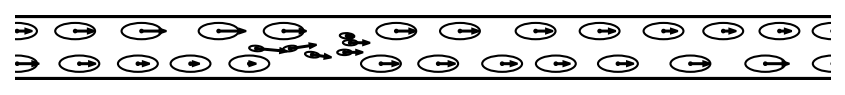

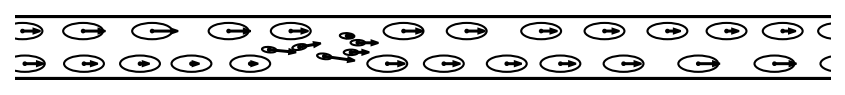

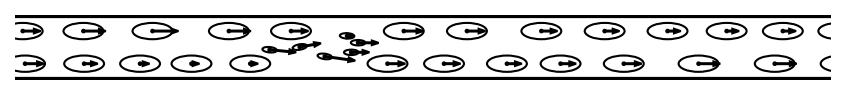

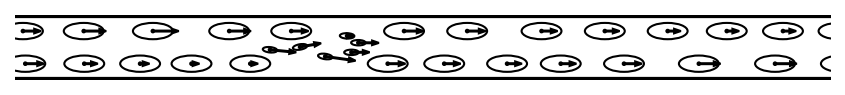

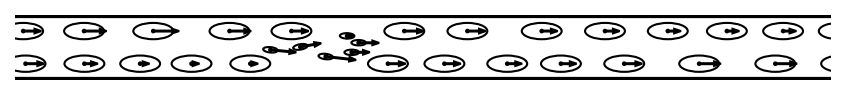

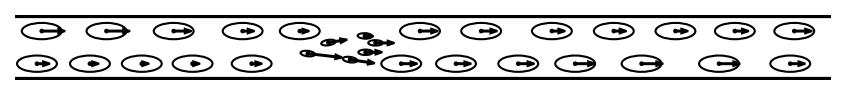

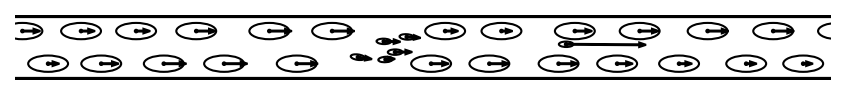

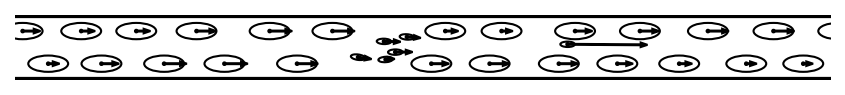

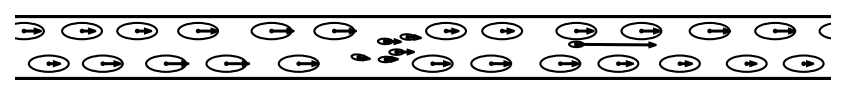

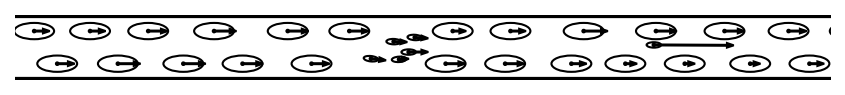

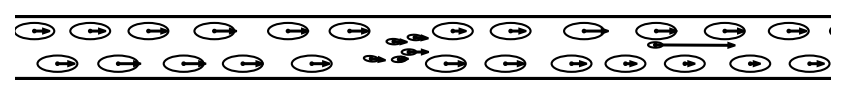

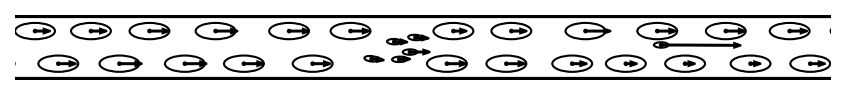

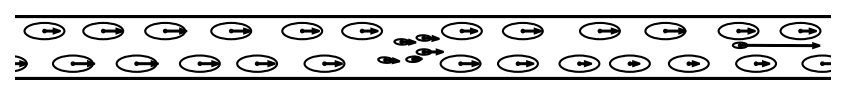

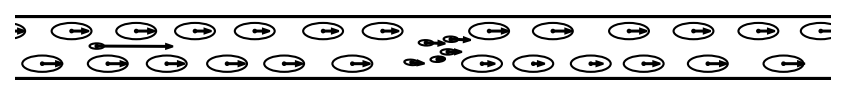

In [66]:
for frame in frames[:]:
    fig, ax = plt.subplots(figsize=(14.7 * params.cm, 2.5 * params.cm), dpi=150)
    fig.tight_layout(pad=0)
    ax.set_aspect("equal")
    ring(int(frame), n_cars, item[0], ax)

## ttc power-law

In [67]:
l_ttc = None
# items = None
dictionary = {}
# Compile the results
compilation = True  # False
min_ttc = 10
max_ttc = 1000
if compilation:
    # for permutation in permutations:
    # if permutation[0] == 14:
    n_cars, n_moto = permutation
    dictionary[str(permutation)] = {
        "xs": [],
        "ps": [],
    }
    # items = loader(permutation)
    l_ttc = []
    for item in items:
        if isinstance(item[0], list):
            for _, agents in enumerate(item[0]):
                for agent in agents:
                    ttc = agent["ttc"]
                    if ttc:
                        l_ttc.append(agent["ttc"])
    a = array(l_ttc)
    a = a[(a > min_ttc) & (a < max_ttc)]
    a_count, a_bins = np.histogram(a, bins=max_ttc)
    a_centers = (a_bins[1:] + a_bins[:-1]) / 2
    a_pdf = a_count / sum(a_count)
    mask = a_pdf > 0
    xs = a_centers[mask]
    ps = a_pdf[mask]
    dictionary[str(permutation)]["xs"] = list(xs)
    dictionary[str(permutation)]["ps"] = list(ps)
    l_ttc = None
    # items = None

In [68]:
def ml_estimator(theta, xs, ps):
    left = 0
    right = 0
    denom = 0
    for xi, pi in zip(xs, ps):
        left += pi * np.log(xi)
        right += (xi ** (-theta)) * np.log(xi)
        denom += xi ** (-theta)
    return left - right / denom

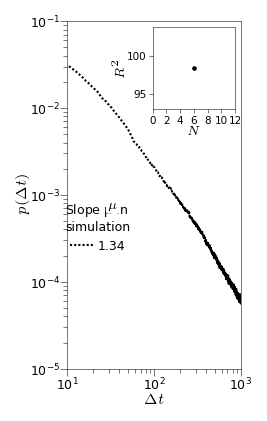

In [69]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 8 * params.cm), dpi=150)
ax.set_aspect("equal")
l_num = []
l_r2 = []
l_mu = []
l_w = []
for key, value in dictionary.items():
    if eval(key)[0] == n_cars:
        num = eval(key)[1]
        l_num.append(num)
        xs = dictionary[key]["xs"]
        ps = dictionary[key]["ps"]

        def g(theta):
            return ml_estimator(theta, xs, ps)

        sol = root_scalar(g, bracket=[1, 3])
        mu = sol.root
        l_mu.append(mu)
        beta = np.median(np.log(ps) + mu * np.log(xs))
        # measure R2
        y_true = ps
        y_pred = np.exp(beta - mu * np.log(xs))
        r2 = r2_score(np.log(y_true), np.log(y_pred))
        l_r2.append(r2)
        ax.plot(xs, ps, c="k", label=f"{mu:.2f}", ls=(0, (1, 1)), lw=1)
a_num = array(l_num)
a_r2 = array(l_r2)
inds = a_num.argsort()
a_n = a_num[inds]
a_r2 = 100 * a_r2[inds]
inset_ax = inset_axes(
    ax,
    width=0.55,
    height=0.55,
    loc=3,
    bbox_to_anchor=(0.45, 0.725, 0, 0),
    bbox_transform=ax.transAxes,
)
inset_ax.plot(a_n, a_r2, c="k", lw=0.5)
inset_ax.scatter(
    a_n,
    a_r2,
    c="k",
    ec="k",
    marker=".",
    s=15,
    zorder=10,
    lw=0.25,
    clip_on=False,
)
ax.legend(
    frameon=False,
    borderpad=0,
    handletextpad=0.25,
    fontsize=6,
    title_fontsize=6,
    loc=1,
    title="Slope $\\mu$ in\nsimulation",
    bbox_to_anchor=(0.4, 0.5),
)
ax.text(
    0.2625,
    0.4525,
    "$\\mu$",
    usetex=True,
    ha="center",
    va="bottom",
    fontsize=6,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
    transform=ax.transAxes,
    zorder=10,
)
inset_ax.set_ylabel("$R^2$", labelpad=0, fontsize=6, usetex=True)
inset_ax.set_xlabel("$N$", labelpad=0, fontsize=6, usetex=True)
inset_ax.tick_params(axis="x", pad=1)
inset_ax.tick_params(axis="y", pad=1)
inset_ax.tick_params(axis="both", which="major", labelsize=5, length=2)
inset_ax.set_xlim(0, 12)
inset_ax.set_xticks([0, 2, 4, 6, 8, 10, 12])
# inset_ax.set_yticks([99.1, 99.3, 99.5, 99.7, 99.9])

ax.set_ylabel("$p(\\Delta t)$", labelpad=0, usetex=True)
ax.set_xlabel("$\\Delta t$", labelpad=0, usetex=True)
ax.set_yscale("log")
ax.set_xscale("log")
ax.tick_params(axis="x", pad=0)
ax.tick_params(axis="y", pad=0)
ax.set_xlim(1e1, 1e3)
ax.set_ylim(1e-5, 1e-1)
fig.tight_layout(pad=0)
# plt.savefig(
#    f"/Users/georg/Documents/Figures/ttc_sim.pdf",
#    format="pdf",
#    transparent=True,
# )
plt.show()

In [70]:
l_r2

[0.9836481315516685]